In [14]:
import os
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [19]:
data_dir = "datasets/data"  # Path to unzipped dataset
img_size = 224
batch_size = 32
num_classes = 10
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [22]:
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

class_names = full_dataset.classes

In [13]:
data_dir

'datasets/data'

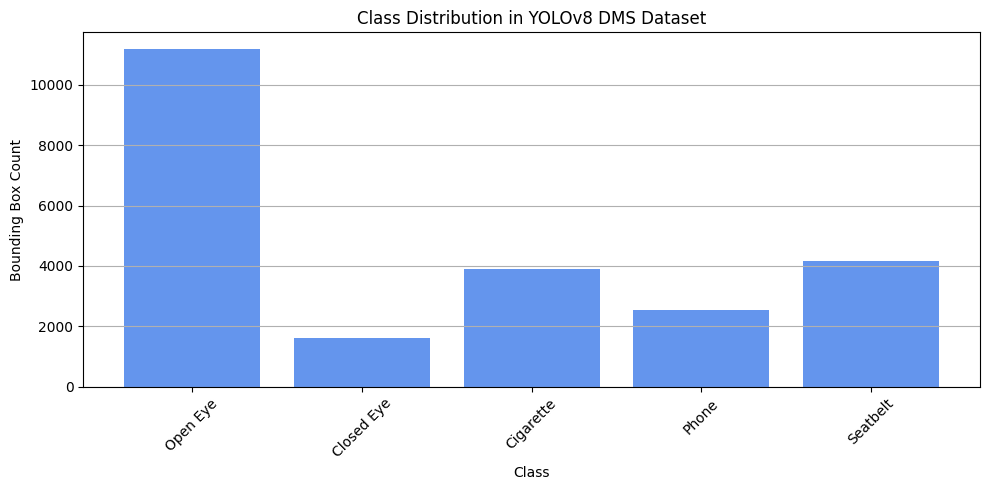

In [24]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Set dataset root directory
dataset_root = "datasets/data"
splits = ['train', 'valid', 'test']
label_ext = '.txt'

# YOLOv8 class mapping
class_names = {
    0: "Open Eye",
    1: "Closed Eye",
    2: "Cigarette",
    3: "Phone",
    4: "Seatbelt"
}

# Count objects across all label files
total_counter = Counter()

for split in splits:
    label_dir = os.path.join(dataset_root, split, "labels")
    if not os.path.exists(label_dir):
        print(f"Warning: {label_dir} not found.")
        continue
    for file in os.listdir(label_dir):
        if file.endswith(label_ext):
            with open(os.path.join(label_dir, file), "r") as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        total_counter[class_id] += 1

# Prepare for plotting
ordered_ids = sorted(total_counter.keys())
frequencies = [total_counter[i] for i in ordered_ids]
labels = [class_names.get(i, f"class_{i}") for i in ordered_ids]

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(labels, frequencies, color='cornflowerblue')
plt.title("Class Distribution in YOLOv8 DMS Dataset")
plt.xlabel("Class")
plt.ylabel("Bounding Box Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



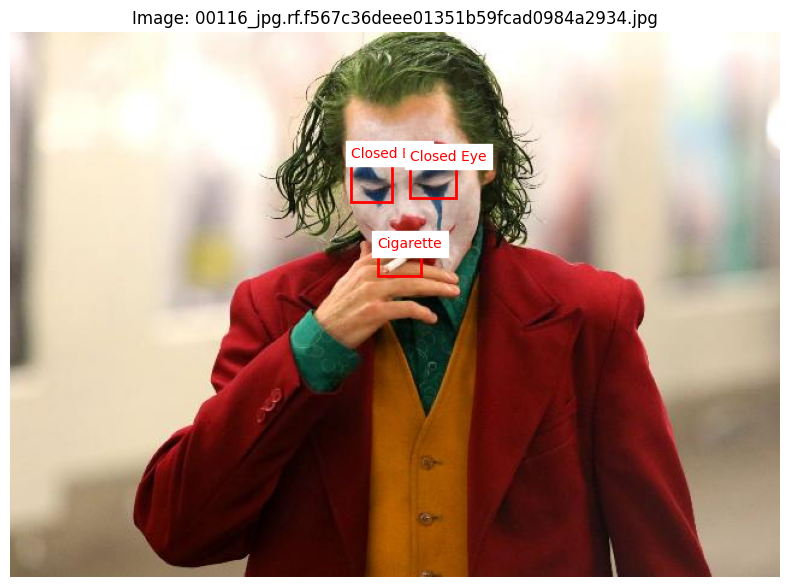

In [25]:
import random
from PIL import Image
import matplotlib.patches as patches

split = "train"  # or "valid" or "test"

image_dir = os.path.join(dataset_root, split, "images")
label_dir = os.path.join(dataset_root, split, "labels")

# Choose random sample
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
sample_file = random.choice(image_files)

# Load image
img_path = os.path.join(image_dir, sample_file)
label_path = os.path.join(label_dir, os.path.splitext(sample_file)[0] + ".txt")
image = Image.open(img_path).convert("RGB")
width, height = image.size

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image)
ax.set_title(f"Image: {sample_file}")

# Draw boxes
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id, x_center, y_center, w, h = map(float, parts)
            x = (x_center - w/2) * width
            y = (y_center - h/2) * height
            box_w = w * width
            box_h = h * height
            label = class_names.get(int(class_id), str(class_id))
            rect = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, label, color='red', fontsize=10, backgroundcolor='white')
else:
    print("Label file not found:", label_path)

plt.axis('off')
plt.tight_layout()
plt.show()

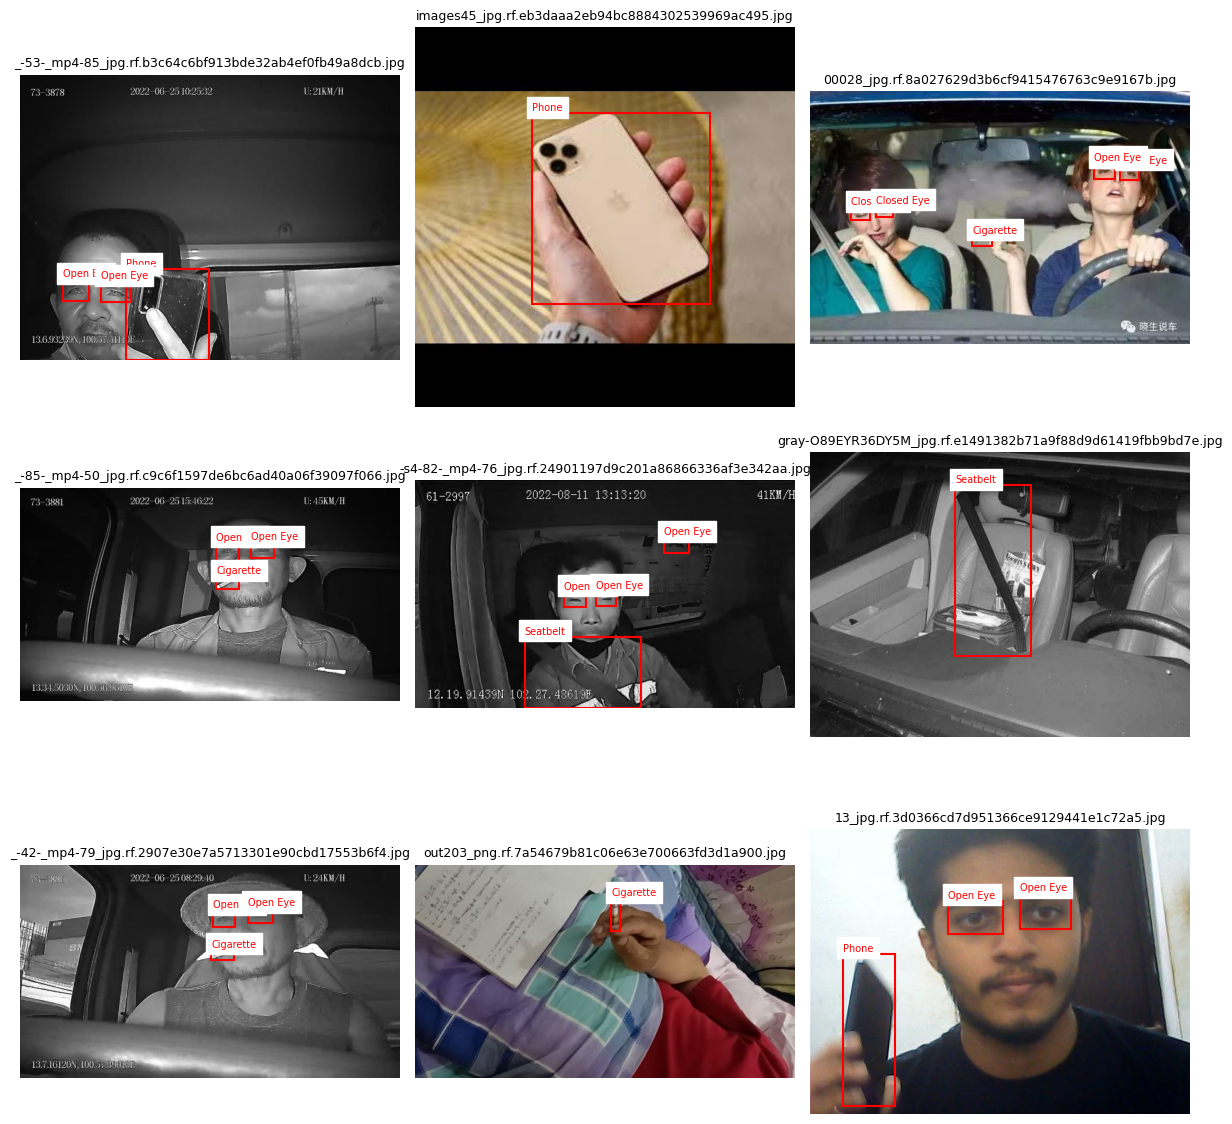

In [26]:
n_images = 9
img_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
selected_files = random.sample(img_files, min(n_images, len(img_files)))

# --- Plot Setup ---
cols = 3
rows = (len(selected_files) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

for ax, filename in zip(axes.flat, selected_files):
    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

    image = Image.open(img_path).convert("RGB")
    width, height = image.size

    ax.imshow(image)
    ax.set_title(filename, fontsize=9)

    # Draw bounding boxes
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id, x_center, y_center, w, h = map(float, parts)
                x = (x_center - w / 2) * width
                y = (y_center - h / 2) * height
                box_w = w * width
                box_h = h * height
                label = class_names.get(int(class_id), str(class_id))
                rect = patches.Rectangle((x, y), box_w, box_h, linewidth=1.5, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y - 5, label, color='red', fontsize=7, backgroundcolor='white')
    else:
        ax.text(0, 0, "No label file found", color='red')

    ax.axis('off')

# Hide unused subplots if any
for i in range(len(selected_files), rows * cols):
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()


In [27]:
from ultralytics import YOLO

# Load a pretrained model (you can choose yolov8n.pt, yolov8s.pt, etc.)
model = YOLO("yolov8n.pt")

# Train the model using the dataset and config
model.train(data="data.yaml", epochs=50, imgsz=410, batch=16)


New https://pypi.org/project/ultralytics/8.3.127 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.126 🚀 Python-3.9.21 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 2080, 7780MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=410, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train15, nbs=64, nms=False, opset=None, optimize=False,

train: Scanning /data/home/alkhaldieid/repos/dms/datasets/data/train/labels.cache... 5957 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5957/5957 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1410.0±581.2 MB/s, size: 26.0 KB)


val: Scanning /data/home/alkhaldieid/repos/dms/datasets/data/valid/labels.cache... 2389 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2389/2389 [00:00<?, ?it/s]


Plotting labels to runs/detect/train15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train15
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.973G      1.578      2.072      1.217         34        416: 100%|██████████| 373/373 [00:29<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:09<00:00,  7.79it/s]


                   all       2389       5773       0.62       0.65      0.673      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.34G      1.376      1.265      1.113         22        416: 100%|██████████| 373/373 [00:27<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.87it/s]


                   all       2389       5773      0.719      0.663      0.726      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.35G      1.337      1.118      1.103         23        416: 100%|██████████| 373/373 [00:26<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.03it/s]

                   all       2389       5773      0.715      0.673      0.708      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.35G      1.301      1.042      1.092         18        416: 100%|██████████| 373/373 [00:26<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.78it/s]


                   all       2389       5773      0.752       0.73      0.778      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.35G      1.257     0.9771      1.075         31        416: 100%|██████████| 373/373 [00:26<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.98it/s]

                   all       2389       5773      0.763      0.706       0.78      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.37G      1.227     0.9228      1.058         22        416: 100%|██████████| 373/373 [00:26<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.11it/s]


                   all       2389       5773        0.8      0.754      0.809      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.38G      1.202     0.9071      1.054         28        416: 100%|██████████| 373/373 [00:26<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.80it/s]

                   all       2389       5773      0.797      0.749      0.821      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.38G      1.176     0.8694      1.043         38        416: 100%|██████████| 373/373 [00:27<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.91it/s]


                   all       2389       5773      0.796      0.778      0.815      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.38G      1.175      0.874      1.043         15        416: 100%|██████████| 373/373 [00:26<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.05it/s]


                   all       2389       5773      0.817      0.778      0.849      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.38G      1.148     0.8366      1.037         27        416: 100%|██████████| 373/373 [00:26<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.00it/s]


                   all       2389       5773      0.833       0.77      0.841      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.38G      1.131     0.8165      1.024         24        416: 100%|██████████| 373/373 [00:27<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.19it/s]


                   all       2389       5773      0.818      0.774      0.835      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.38G      1.126     0.8055       1.03         11        416: 100%|██████████| 373/373 [00:26<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.11it/s]


                   all       2389       5773      0.827      0.776      0.842      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.38G      1.108     0.7927      1.017         18        416: 100%|██████████| 373/373 [00:27<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.65it/s]


                   all       2389       5773      0.837      0.784      0.847      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.38G      1.106     0.7786      1.016         23        416: 100%|██████████| 373/373 [00:26<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:08<00:00,  9.07it/s]


                   all       2389       5773      0.842      0.799      0.866      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.38G      1.082     0.7631      1.011         20        416: 100%|██████████| 373/373 [00:26<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.15it/s]

                   all       2389       5773      0.788      0.765      0.847       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.38G      1.079     0.7591      1.005         26        416: 100%|██████████| 373/373 [00:27<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.20it/s]

                   all       2389       5773      0.866      0.812      0.878      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.38G      1.067     0.7446      1.005         33        416: 100%|██████████| 373/373 [00:26<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.18it/s]


                   all       2389       5773      0.852      0.819      0.867      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.38G      1.064     0.7299      1.002         28        416: 100%|██████████| 373/373 [00:27<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.25it/s]

                   all       2389       5773       0.85      0.806      0.871      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.38G      1.049     0.7309     0.9976         18        416: 100%|██████████| 373/373 [00:27<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.21it/s]


                   all       2389       5773      0.853      0.809      0.865      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.38G      1.043     0.7217      0.997         26        416: 100%|██████████| 373/373 [00:26<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.93it/s]


                   all       2389       5773      0.853      0.805      0.869      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.38G      1.034      0.707     0.9983         36        416: 100%|██████████| 373/373 [00:27<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.75it/s]


                   all       2389       5773      0.859      0.827      0.886        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.38G      1.025     0.6927     0.9889         13        416: 100%|██████████| 373/373 [00:26<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.05it/s]


                   all       2389       5773      0.843      0.813      0.867       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.38G      1.011     0.6901     0.9853         24        416: 100%|██████████| 373/373 [00:27<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.28it/s]


                   all       2389       5773      0.856      0.828      0.885      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.38G      1.013     0.6827      0.982         15        416: 100%|██████████| 373/373 [00:26<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.02it/s]

                   all       2389       5773      0.849      0.806      0.869      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.38G      1.007     0.6857     0.9848         18        416: 100%|██████████| 373/373 [00:26<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.75it/s]

                   all       2389       5773      0.861      0.844      0.888      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.38G      1.004     0.6712     0.9854         18        416: 100%|██████████| 373/373 [00:27<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.40it/s]


                   all       2389       5773      0.867      0.842      0.893      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.38G     0.9889     0.6623      0.977         31        416: 100%|██████████| 373/373 [00:27<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.51it/s]


                   all       2389       5773      0.864      0.843      0.894      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.38G     0.9898     0.6617     0.9794         21        416: 100%|██████████| 373/373 [00:26<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.59it/s]

                   all       2389       5773      0.869      0.845      0.894      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.38G      0.977     0.6506     0.9744         21        416: 100%|██████████| 373/373 [00:27<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.47it/s]

                   all       2389       5773      0.881      0.832      0.895       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.38G     0.9756     0.6481     0.9709         34        416: 100%|██████████| 373/373 [00:27<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.51it/s]


                   all       2389       5773      0.864      0.845      0.892      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.38G     0.9699     0.6386     0.9694         17        416: 100%|██████████| 373/373 [00:27<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.45it/s]

                   all       2389       5773      0.898      0.835      0.899      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.38G     0.9639     0.6287     0.9661         29        416: 100%|██████████| 373/373 [00:27<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:08<00:00,  9.15it/s]


                   all       2389       5773      0.891      0.838      0.897      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.38G     0.9569     0.6266     0.9659         19        416: 100%|██████████| 373/373 [00:27<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.67it/s]

                   all       2389       5773      0.877      0.843      0.898      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.38G     0.9512     0.6183     0.9646         30        416: 100%|██████████| 373/373 [00:26<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.56it/s]

                   all       2389       5773      0.885      0.835        0.9      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.38G     0.9459     0.6173     0.9616         26        416: 100%|██████████| 373/373 [00:27<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.54it/s]

                   all       2389       5773      0.885      0.845      0.906      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.38G      0.942     0.6153     0.9631         21        416: 100%|██████████| 373/373 [00:27<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.71it/s]


                   all       2389       5773      0.886      0.839      0.904      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.38G     0.9351     0.6081     0.9577         39        416: 100%|██████████| 373/373 [00:27<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.57it/s]

                   all       2389       5773      0.884      0.841        0.9      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.38G     0.9292     0.6035      0.953         25        416: 100%|██████████| 373/373 [00:27<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.69it/s]

                   all       2389       5773      0.887      0.838      0.903      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.38G     0.9215     0.5909     0.9556         28        416: 100%|██████████| 373/373 [00:27<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:08<00:00,  9.12it/s]

                   all       2389       5773      0.874      0.852      0.905      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.38G     0.9174     0.5876     0.9528         25        416: 100%|██████████| 373/373 [00:27<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.39it/s]


                   all       2389       5773      0.893      0.849      0.911      0.642
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.38G     0.8683     0.5111     0.9222         13        416: 100%|██████████| 373/373 [00:27<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.80it/s]

                   all       2389       5773      0.885      0.842      0.904      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.38G     0.8507     0.4969     0.9151         14        416: 100%|██████████| 373/373 [00:26<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.79it/s]


                   all       2389       5773      0.896      0.836      0.903      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.38G      0.839     0.4941     0.9137         13        416: 100%|██████████| 373/373 [00:26<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.62it/s]

                   all       2389       5773      0.886      0.849      0.905      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.38G     0.8308     0.4849     0.9105         14        416: 100%|██████████| 373/373 [00:26<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.50it/s]


                   all       2389       5773      0.881      0.857      0.909      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.38G     0.8261     0.4784     0.9079         13        416: 100%|██████████| 373/373 [00:26<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00, 10.06it/s]

                   all       2389       5773      0.884      0.859      0.909      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.38G     0.8162     0.4693      0.903         12        416: 100%|██████████| 373/373 [00:26<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.54it/s]

                   all       2389       5773      0.889      0.852      0.909      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.38G     0.8084     0.4633     0.9004         12        416: 100%|██████████| 373/373 [00:27<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.87it/s]

                   all       2389       5773      0.889      0.851      0.908      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.38G     0.8014     0.4603      0.901          9        416: 100%|██████████| 373/373 [00:26<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.80it/s]

                   all       2389       5773      0.879      0.873      0.913      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.38G     0.7915     0.4525     0.8983         11        416: 100%|██████████| 373/373 [00:27<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.62it/s]

                   all       2389       5773      0.883      0.863       0.91      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.38G     0.7928     0.4517     0.8977         16        416: 100%|██████████| 373/373 [00:27<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.80it/s]

                   all       2389       5773      0.888      0.866      0.912      0.647



50 epochs completed in 0.491 hours.
Optimizer stripped from runs/detect/train15/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train15/weights/best.pt, 6.2MB

Validating runs/detect/train15/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.9.21 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 2080, 7780MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:09<00:00,  8.08it/s]


                   all       2389       5773      0.882      0.864       0.91      0.648
              Open Eye       1485       2710      0.896      0.955      0.976      0.776
            Closed Eye        358        530      0.811      0.754      0.855      0.644
             Cigarette        430        453       0.83      0.751      0.802      0.431
                 Phone        504        588      0.969      0.949      0.976      0.723
              Seatbelt       1461       1492      0.905       0.91      0.942      0.667
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train15


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x791cb8d503a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        